Let's look at stuff.

In [1]:
## dataframe libraries
import pandas as pd
import numpy as np

## plotting libraries
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
df = pd.read_csv('../data/JP_STOPS_MEASURES.csv')

print(df.columns)
print("{} rows".format(len(df)))

Index(['Unnamed: 0', 'name', 'utterance_label', 'utterance_start',
       'utterance_end', 'C1_start', 'C1_end', 'V1_start', 'V1_end', 'C2_start',
       'C2_end', 'V2_start', 'V2_end', 'release', 'voicing', 'speaker',
       'speaker_trial', 'speaker_id', 'recording_date', 'birth_year',
       'birth_date', 'gender', 'dialect_eng', 'birthplace_eng',
       'eight_regions_of_Japan_eng', 'prefecture_eng',
       'province_of_Japan_(administrative_divisions_of_Japan_from_the_600s_to_1868)_eng',
       'dialect_jpn', 'birthplace_jpn', 'eight_regions_of_Japan_jpn',
       'prefecture_jpn',
       'province_of_Japan_(administrative_divisions_of_Japan_from_the_600s_to_1868)_jpn',
       'Linguistic_environment', 'Father's_birthplace', 'Mother's_birthplace',
       '備考', 'serial_mumber', 'trial', 'label(order_in_a_trial)', 'word_kanji',
       'word_phonemic', 'meaning', 'consonant', 'vowel', 'place',
       'phone_voicing', 'type', 'VOT', 'F0', 'file_amplitude',
       'burst_amplitude'],
  

In [3]:
## remove missing pitch and VOT values
df = df.dropna(subset = ['F0', 'VOT', 'burst_amplitude'])

## check number of tokens per dialect
print(df.groupby(['dialect_eng']).size())

dialect_eng
Aichi_Owari         57
Ehime_Iyo          137
Hiroshima_Aki       44
Hyogo_Settsu        49
Kobe               527
Kyoto_Yamachiro     47
Osaka_Kawachi       50
Osaka_Settsu       372
Saga               557
Shiga_Oumi          40
Tokyo              536
Unpaku              41
dtype: int64


In [ ]:
## center burst amplitude based on the file-average amplitude
df['amplitude'] = df['burst_amplitude'] - df['file_amplitude']

## convert VOT to milliseconds
df['VOT'] = df['VOT'] * 1000

## normalise F0 values within speaker
## get speaker F0 mean + sd
speakerF0 = df.groupby(['speaker'], as_index = False).agg(
    meanF0 = ("F0", "mean"),
    sdF0 = ("F0", "std"))

## merge into main dataframe
## and z-normalise
df = pd.merge(df, speakerF0)
df['F0_norm'] = (df['F0'] - df['meanF0']) / df['sdF0']

    speaker phone_voicing        VOT   F0_norm  amplitude
0     acmry        voiced -78.357143  0.164382  14.318667
1     acmry     voiceless  44.671724 -0.158714   5.191320
2     ehfmk        voiced -40.560000 -0.384483   6.557272
3     ehfmk     voiceless  37.260435  0.434633  -0.666840
4     ehfsk        voiced -22.363158 -0.512214  -0.184564
..      ...           ...        ...       ...        ...
97     ummi     voiceless  53.280833  0.723493   0.735108
98     umro        voiced   3.499062 -0.495640  12.486813
99     umro     voiceless  38.792424  0.480620   5.996251
100    umso        voiced  34.496562 -0.634483   3.220588
101    umso     voiceless  52.396364  0.615256   3.011107

[102 rows x 5 columns]


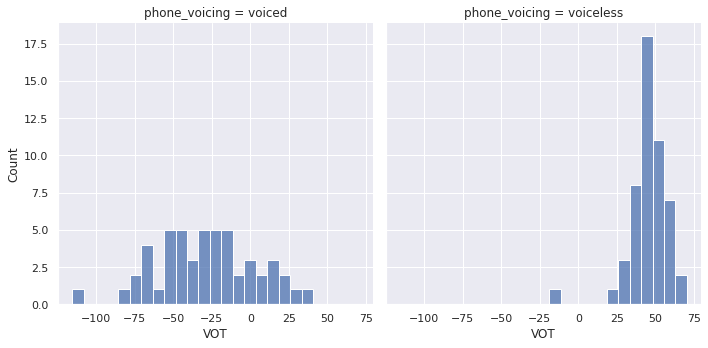

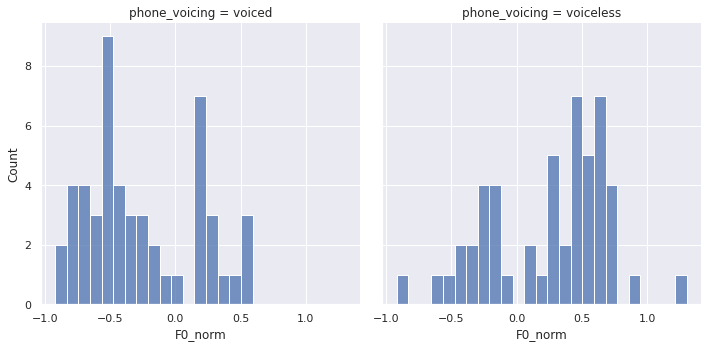

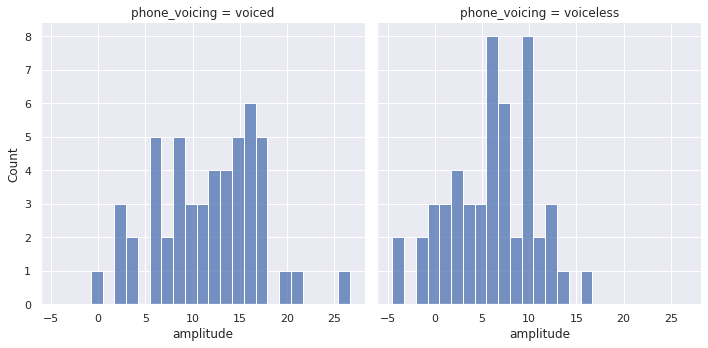

In [4]:
## and averaging for speakers' average voiced/voiceless values
speakerdf = df.groupby(['speaker', 'phone_voicing'], as_index = False)[['VOT', 'F0_norm', 'amplitude']].mean()
print(speakerdf)


sns.displot(speakerdf, x = 'VOT', col = 'phone_voicing', bins = 25)
sns.displot(speakerdf, x = 'F0_norm', col = 'phone_voicing', bins = 25)
sns.displot(speakerdf, x = 'amplitude', col = 'phone_voicing', bins = 25)
## plot F0 by phone voicing
#sns.displot(df, x = 'F0', col = 'phone_voicing')

Let's see how individual dialects use the acoustic cues for marking voiced and voiceless stops.

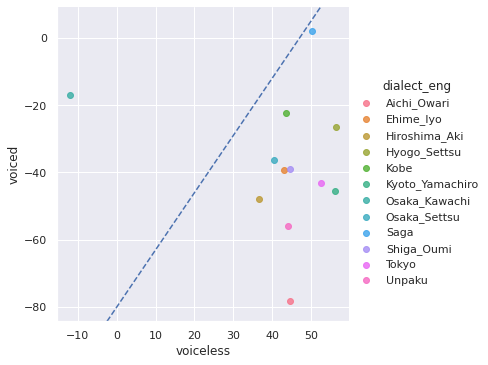

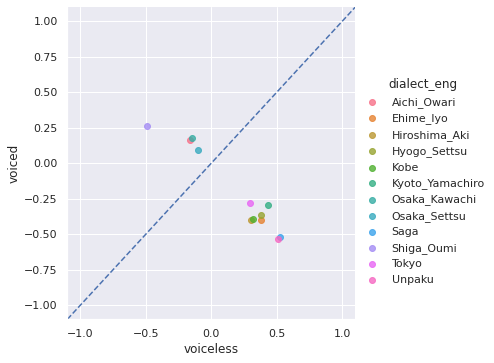

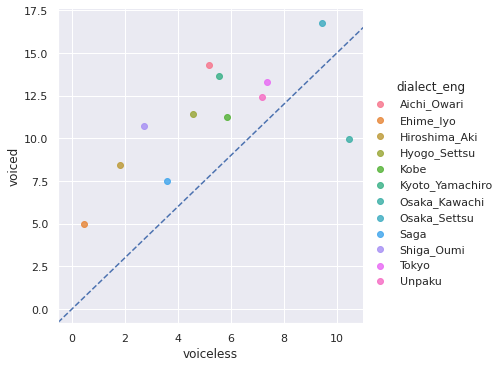

In [5]:
## Get each speaker's mean voiced and voiceless VOT
DialectDf = (df.groupby(['speaker', 'dialect_eng', 'phone_voicing'], as_index = False)[['VOT', 'F0_norm', 'amplitude']].mean()
                
                ## Get dialect as a mean of speaker means
                .groupby(['dialect_eng', 'phone_voicing'], as_index = False)[['VOT', 'F0_norm', 'amplitude']].mean()
                
                ## convert phone voicings into separate columns
                .pivot(index = 'dialect_eng', columns = 'phone_voicing').reset_index()
)

def ContrastPlot(df, min_x, min_y, max_x, max_y):
    sns.lmplot(x = 'voiceless', y = 'voiced', hue = 'dialect_eng', data = df)
    plt.axline((min_x, min_y), (max_x, max_y), linestyle = "--")

VOTdf = DialectDf['VOT'].copy()
VOTdf.loc[:, 'dialect_eng'] = DialectDf['dialect_eng'].values
ContrastPlot(VOTdf, 0, -80, 50, 5)
             
F0df = DialectDf['F0_norm'].copy()
F0df.loc[:, 'dialect_eng'] = DialectDf['dialect_eng'].values
ContrastPlot(F0df, -1, -1, 1, 1)

Ampdf = DialectDf['amplitude'].copy()
Ampdf.loc[:, 'dialect_eng'] = DialectDf['dialect_eng'].values
ContrastPlot(Ampdf, 0, 0, 10, 15)



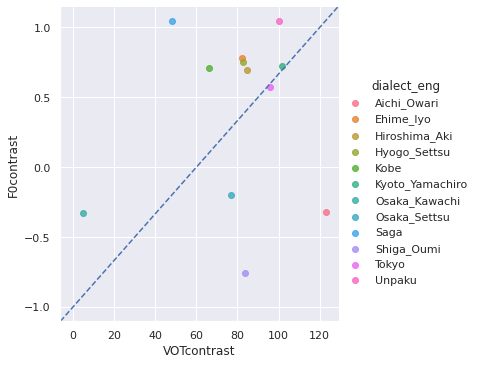

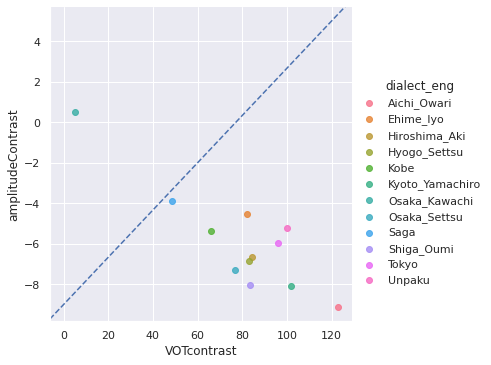

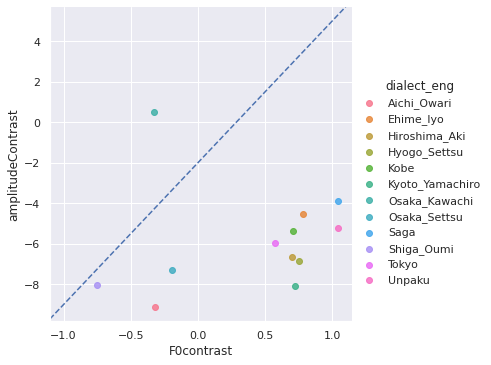

In [6]:
## now plot the dialectal-difference in the relationship between the VOT and F0 voicing contrast
DialectContrastDf = (df.groupby(['speaker', 'dialect_eng', 'phone_voicing'], as_index = False)[['VOT', 'F0_norm', 'amplitude']].mean()
                     .groupby(['dialect_eng', 'phone_voicing'], as_index = False)[['VOT', 'F0_norm', 'amplitude']].mean()
                     .pivot(index = 'dialect_eng', columns = 'phone_voicing', values = ['VOT', 'F0_norm', 'amplitude']).reset_index())

DialectContrastDf['VOTcontrast'] = DialectContrastDf['VOT']['voiceless'] - DialectContrastDf['VOT']['voiced']
DialectContrastDf['F0contrast'] = DialectContrastDf['F0_norm']['voiceless'] - DialectContrastDf['F0_norm']['voiced']
DialectContrastDf['amplitudeContrast'] = DialectContrastDf['amplitude']['voiceless'] - DialectContrastDf['amplitude']['voiced']

sns.lmplot(x = 'VOTcontrast', y = 'F0contrast', hue = 'dialect_eng', data = DialectContrastDf)
plt.axline((0,-1), (120, 1), linestyle = '--')

sns.lmplot(x = 'VOTcontrast', y = 'amplitudeContrast', hue = 'dialect_eng', data = DialectContrastDf)
plt.axline((0, -9), (120, 5), linestyle = '--')

sns.lmplot(x = 'F0contrast', y = 'amplitudeContrast', hue = 'dialect_eng', data = DialectContrastDf)
plt.axline((-1, -9), (1, 5), linestyle = '--')